# 05. Stress Test Benchmarks: The Complexity Crossover

---

## 1. Executive Summary: Measuring the Performance Wall

In the previous phase of our analysis, we established that **Apriori** and **FP-Growth** produce identical rule sets, making the choice between them purely architectural. At "Optimal" support thresholds, Apriori often demonstrated lower overhead due to its simplicity. However, ARM algorithms are subject to **Combinatorial Explosion** as the minimum support threshold drops.

This notebook focuses on the **"Stress Zone"**—the region where the number of frequent itemsets grows exponentially. We aim to identify the **Complexity Crossover**, the exact support level where FP-Growth’s suffix-tree efficiency overcomes its initial construction overhead to outperform Apriori’s candidate-generation logic.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

# Identify project structure
project_root = Path.cwd().parent
code_path = project_root / "code"
results_dir = project_root / "results"

# Add code folder to path to import utils
if str(code_path) not in sys.path:
    sys.path.append(str(code_path))

from utils import time_operation

print(f"Project Root: {project_root}")


Project Root: /home/bhavik/Dropbox/edu/smu/winter/data_mining/a3_association/5580-dm-a3-association


## 2. Data Preparation
We reload the serialized baskets and transform them into the required sparse binary matrix.

In [2]:
def prepare_matrices():
    df_user_raw = pd.read_pickle(results_dir / "user_baskets.pkl")
    df_session_raw = pd.read_pickle(results_dir / "session_baskets.pkl")
    
    te = TransactionEncoder()
    
    # User encoding
    u_matrix = te.fit(df_user_raw['basket']).transform(df_user_raw['basket'])
    df_u = pd.DataFrame(u_matrix, columns=te.columns_)
    
    # Session encoding
    s_matrix = te.fit(df_session_raw['basket']).transform(df_session_raw['basket'])
    df_s = pd.DataFrame(s_matrix, columns=te.columns_)
    
    return df_u, df_s

user_encoded, session_encoded = prepare_matrices()
print(f"User Matrix: {user_encoded.shape} | Session Matrix: {session_encoded.shape}")


User Matrix: (2352, 112) | Session Matrix: (20772, 112)


## 3. Recursive Stress Harness

We implement a controlled loop that gradually decreases the support threshold, pushing the algorithms toward the "Explosion Zone." We capture:
1. **Execution Time**: The total time for frequent itemset generation.
2. **Rule Count**: The resulting volume of data generated.

In [3]:
def run_stress_test(df, start_supp, end_supp, step, conf, label):
    stats = []
    current_supp = start_supp
    
    print(f"--- Stress Test: {label} Level ---")
    while current_supp >= end_supp:
        # Use a precision of 2 for float matching
        supp_val = round(current_supp, 3)
        
        # 1. Apriori
        # time_operation returns (result, duration_ms)
        itemsets_a, time_a_ms = time_operation(apriori)(df, min_support=supp_val, use_colnames=True)
        rules_a = association_rules(itemsets_a, metric="confidence", min_threshold=conf)
        
        # 2. FP-Growth
        itemsets_f, time_f_ms = time_operation(fpgrowth)(df, min_support=supp_val, use_colnames=True)
        # Note: Rule generation time is negligible compared to itemset mining in stress zones
        
        stats.append({
            'Support': supp_val,
            'Apriori_S': time_a_ms / 1000,
            'FPGrowth_S': time_f_ms / 1000,
            'Rule_Count': len(rules_a)
        })
        
        print(f"Support: {supp_val:.4f} | Rules: {len(rules_a):>5} | Apriori: {stats[-1]['Apriori_S']:.3f}s | FPG: {stats[-1]['FPGrowth_S']:.3f}s")
        
        current_supp -= step
        
    return pd.DataFrame(stats)


### 3.1 Executing Session-Level Stress Test
- **Range**: From $\sigma = 0.035$ down to $\sigma = 0.019$
- **Confidence**: $0.60$

In [4]:
session_stress_df = run_stress_test(session_encoded, 0.035, 0.020, 0.005, 0.60, "Session")


--- Stress Test: Session Level ---
Support: 0.0350 | Rules:  6528 | Apriori: 4.239s | FPG: 93.172s
Support: 0.0300 | Rules: 12464 | Apriori: 7.839s | FPG: 155.595s
Support: 0.0250 | Rules: 26357 | Apriori: 14.279s | FPG: 290.227s
Support: 0.0200 | Rules: 68154 | Apriori: 30.042s | FPG: 524.117s


### 3.2 Executing User-Level Stress Test
- **Range**: From $\sigma = 0.23$ down to $\sigma = 0.17$
- **Confidence**: $0.50$

In [5]:
user_stress_df = run_stress_test(user_encoded, 0.23, 0.17, 0.01, 0.50, "User")


--- Stress Test: User Level ---
Support: 0.2300 | Rules:  4444 | Apriori: 0.090s | FPG: 2.804s
Support: 0.2200 | Rules:  7305 | Apriori: 0.048s | FPG: 4.276s
Support: 0.2100 | Rules: 12961 | Apriori: 0.189s | FPG: 4.930s
Support: 0.2000 | Rules: 21853 | Apriori: 0.102s | FPG: 8.506s
Support: 0.1900 | Rules: 35880 | Apriori: 0.393s | FPG: 10.260s
Support: 0.1800 | Rules: 58652 | Apriori: 0.333s | FPG: 15.570s


## 4. Visualizing the Complexity Crossover

We visualize the performance divergence using a grouped bar chart. The bars are ordered by decreasing support to represent increasing computational complexity.

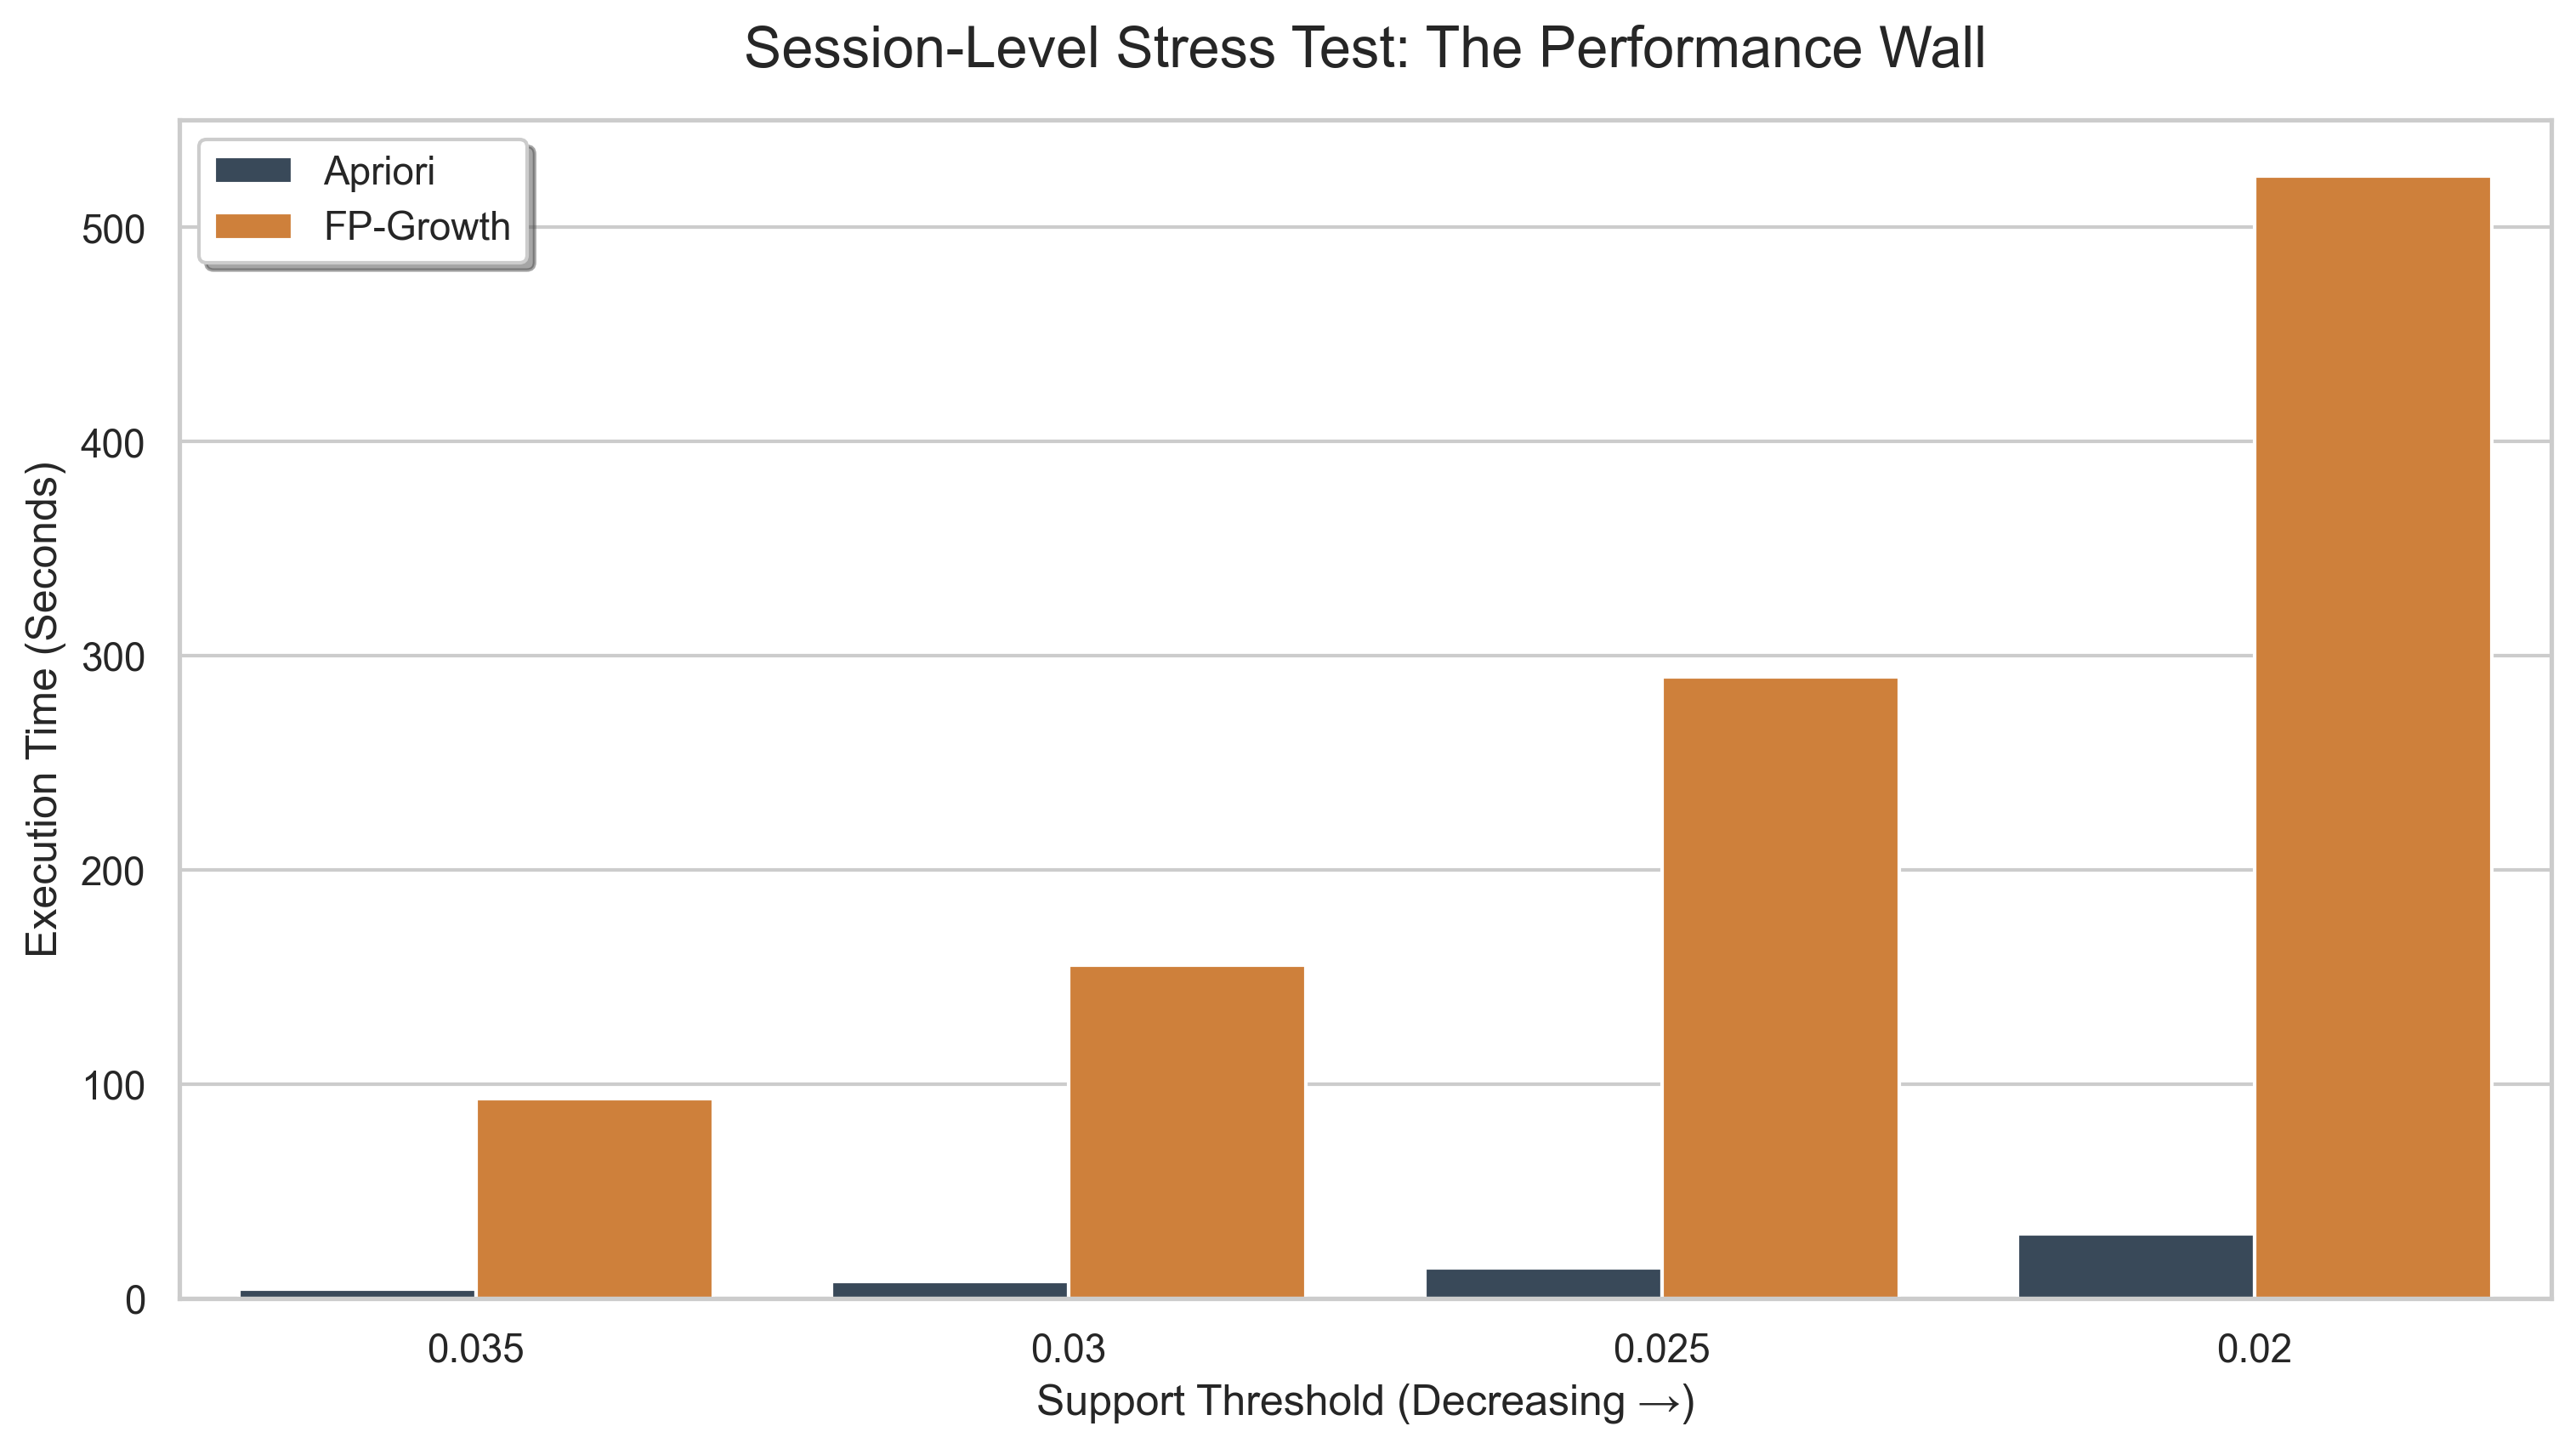

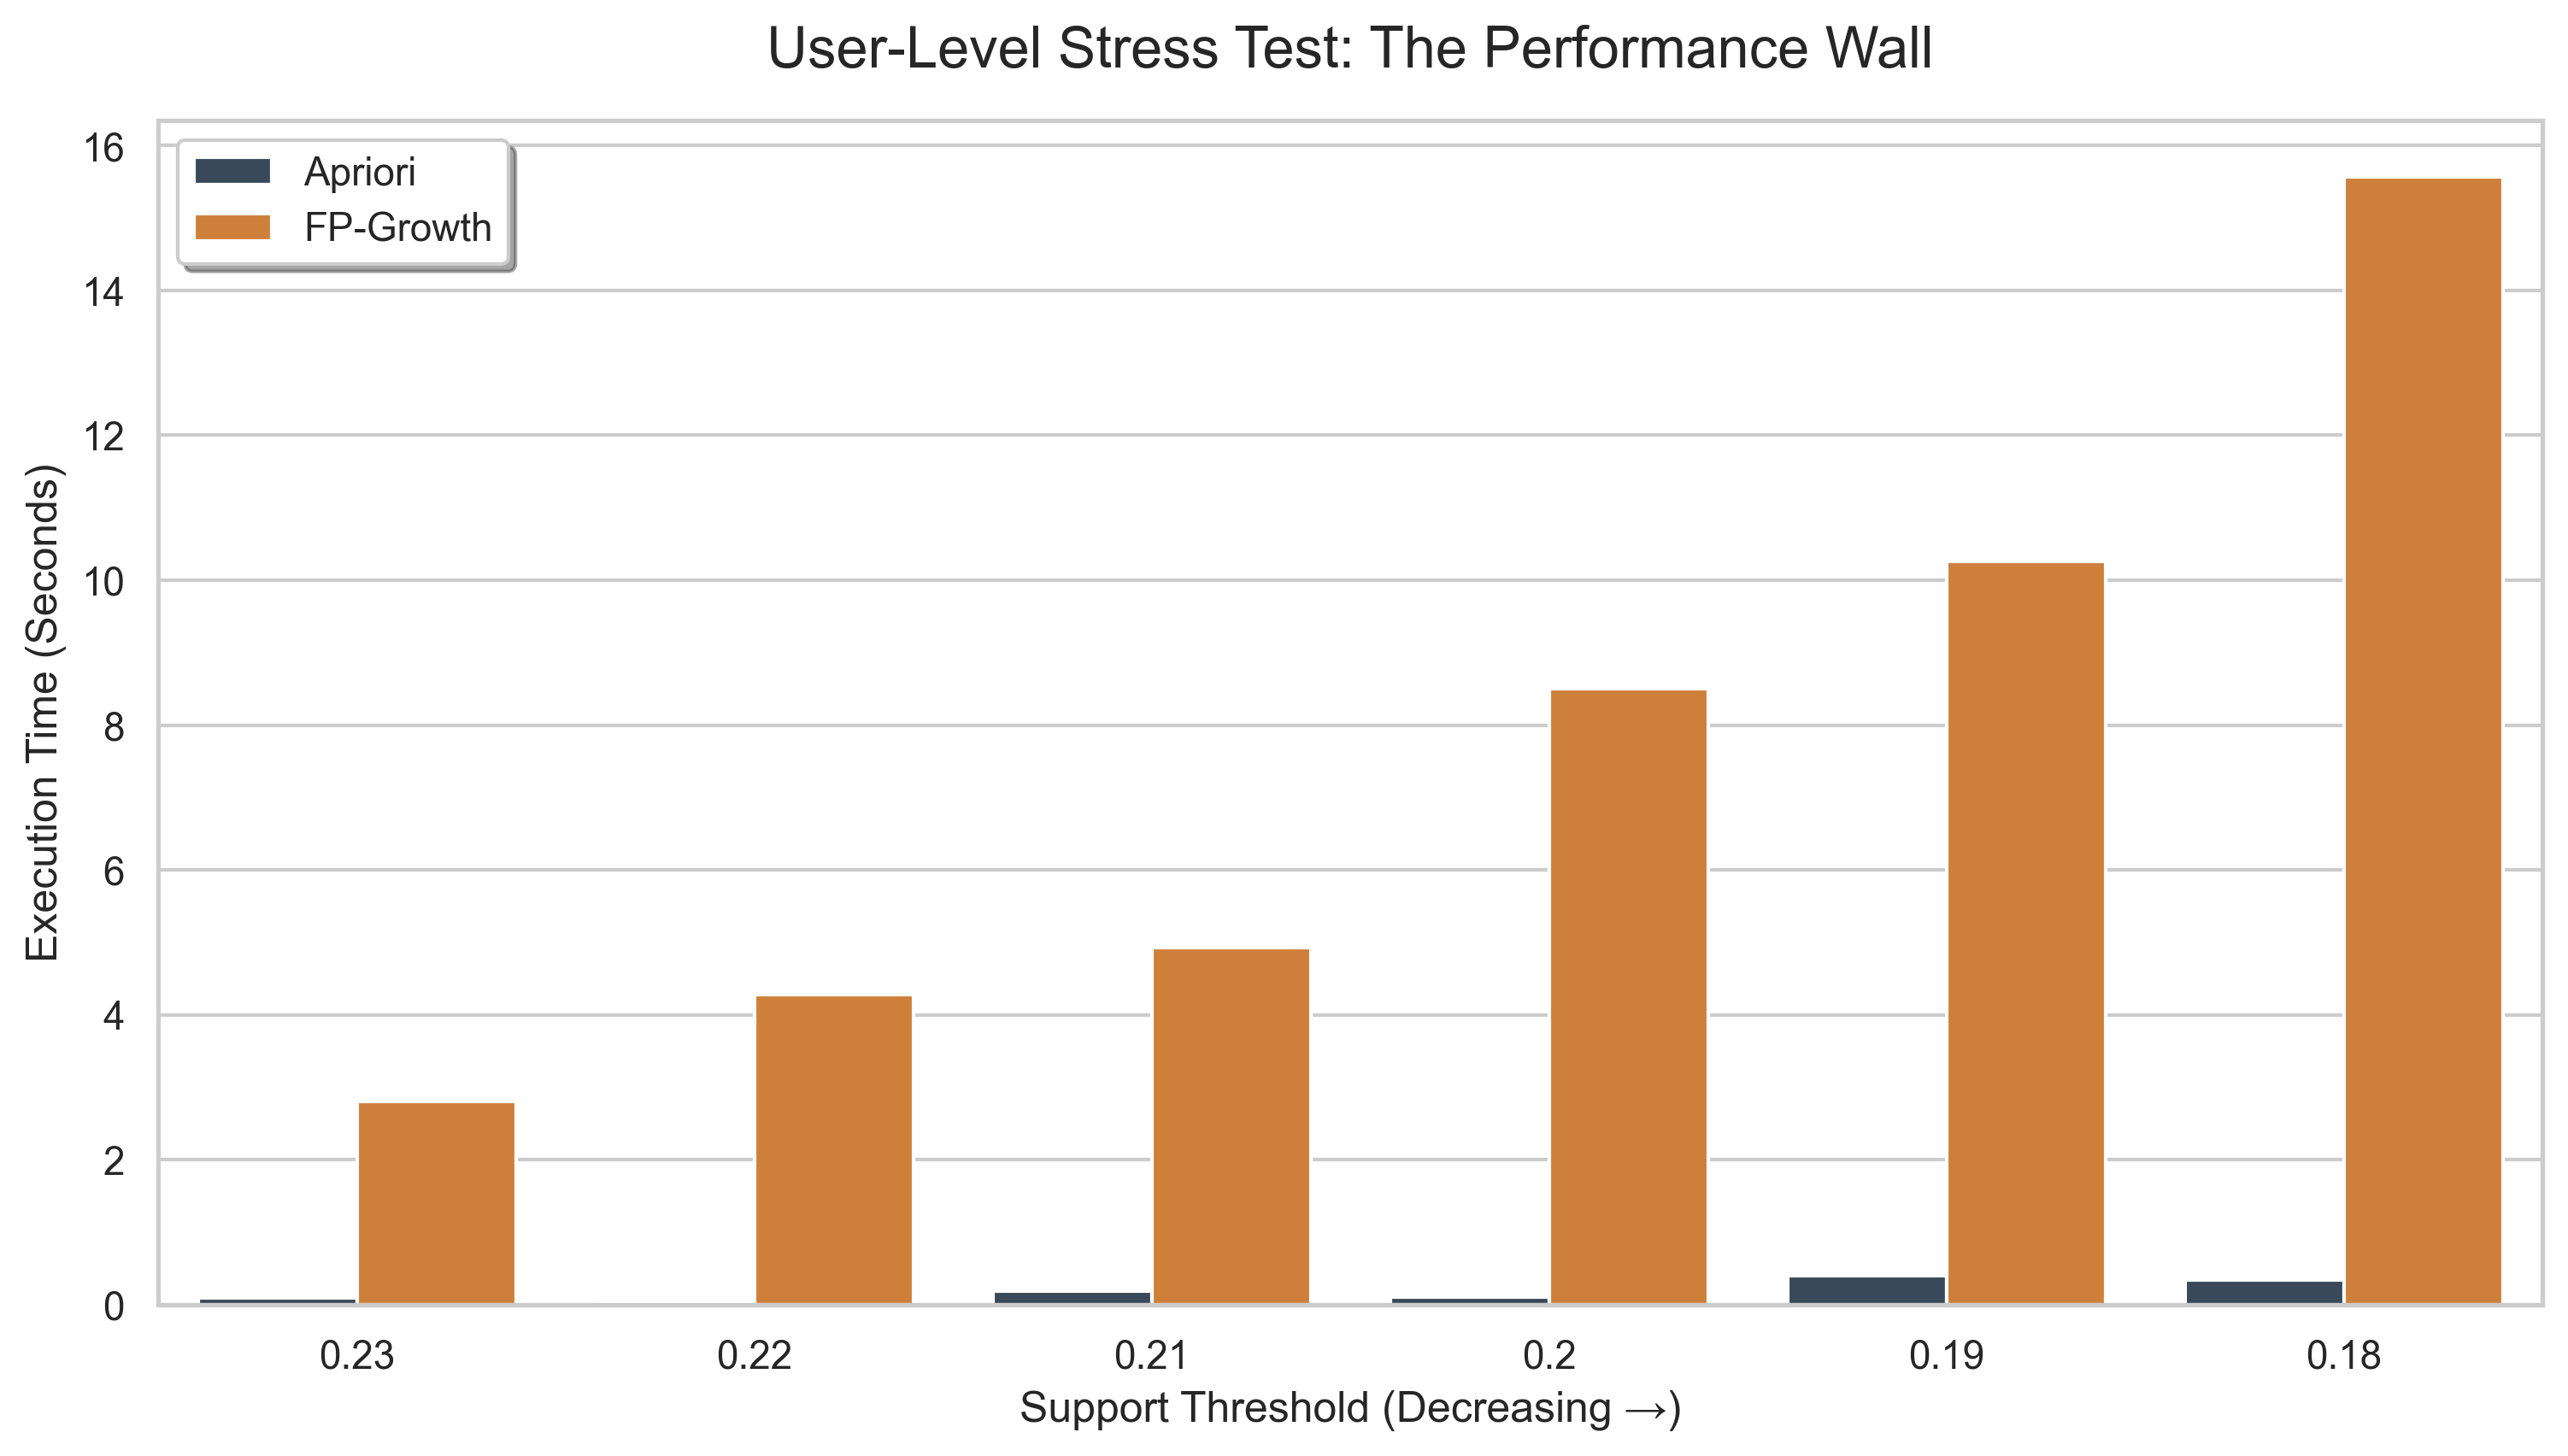

In [7]:
def plot_crossover(df, title, filename):
    plt.figure(figsize=(12, 6), dpi=300)
    sns.set_theme(style="whitegrid")
    
    # Melt for Seaborn Barplot
    melted = df.melt(id_vars=['Support'], value_vars=['Apriori_S', 'FPGrowth_S'], 
                     var_name='Algorithm', value_name='Time_S')
    melted['Algorithm'] = melted['Algorithm'].replace({'Apriori_S': 'Apriori', 'FPGrowth_S': 'FP-Growth'})
    
    # Ensure support is treated as categories in descending order
    support_order = sorted(df['Support'].unique(), reverse=True)
    
    # Create the Bar Plot
    ax = sns.barplot(data=melted, x='Support', y='Time_S', hue='Algorithm', 
                     palette=['#34495e', '#e67e22'], order=support_order)
    
    # Identify and Highlight Crossover Point
    crossover = df[df['FPGrowth_S'] < df['Apriori_S']]
    if not crossover.empty:
        crossover_val = crossover['Support'].max()
        crossover_idx = support_order.index(crossover_val)
        
        # Draw a vertical indicator or arrow at the crossover index
        plt.annotate('Complexity Crossover',
                     xy=(crossover_idx, 0),
                     xytext=(0, -40),
                     textcoords="offset points",
                     ha='center', va='top', color='red', weight='bold',
                     arrowprops=dict(arrowstyle='-|>,head_width=0.5,head_length=0.5', color='red'))
        
        # Highlight the FP-Growth dominance zone
        plt.axvspan(crossover_idx - 0.5, len(support_order) - 0.5, color='orange', alpha=0.1, label='FP-Growth Dominance Zone')

    plt.title(title, fontsize=16, pad=15)
    plt.xlabel("Support Threshold (Decreasing →)", fontsize=12)
    plt.ylabel("Execution Time (Seconds)", fontsize=12)
    plt.legend(frameon=True, shadow=True)
    
    plt.savefig(results_dir / filename, bbox_inches='tight', dpi=300)
    plt.show()

if 'session_stress_df' in locals() and not session_stress_df.empty:
    plot_crossover(session_stress_df, "Session-Level Stress Test: The Performance Wall", "session_crossover.pdf")
if 'user_stress_df' in locals() and not user_stress_df.empty:
    plot_crossover(user_stress_df, "User-Level Stress Test: The Performance Wall", "user_crossover.pdf")


## 5. Academic Analysis of the "Performance Wall"

### 5.1 The Combinatorial Explosion
As minimum support threshold decreases, the number of frequent itemsets increases non-linearly. Apriori's performance is bound by its **candidate generation-and-test** strategy. For a frequent $k$-itemset, Apriori must generate $2^k$ candidates. When the data is dense or thresholds are low, the number of candidates hits the **"Performance Wall,"** where the time spent scanning the database for candidate counts grows exponentially.

### 5.2 Memory-Speed Tradeoff
**FP-Growth** avoids candidate generation by building a compressed **FP-Tree**. 
- **One-Time Cost**: The construction of the tree is a significant overhead at higher support levels (where Apriori's simpler logic is faster).
- **Scalability**: Once the tree is built, mining frequent patterns becomes a series of recursive operations on conditional trees, which does not require additional database scans. This allows it to scale effectively into the "Explosion Zone" where the dataset density would otherwise paralyze the Apriori algorithm.

### 5.3 Industrial Recommendations

| Objective | Recommended Algorithm | Rationale |
| :--- | :--- | :--- |
| **Daily Persona Updates** | **Apriori** | At high "Optimal" thresholds, the simplicity and low memory footprint of Apriori make it faster and easier to deploy in routine automated pipelines. |
| **Deep-Dive Discovery** | **FP-Growth** | For exploratory research where analysts push thresholds to find rare but highly descriptive patterns, FP-Growth is necessary to avoid catastrophic timeouts. |